In [9]:
import numpy as np
from numpy.linalg import eig, inv
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy import interpolate
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.labelweight'] = 0

In [2]:
# Fitting algorism
class Profile:
    def __init__(self, depth_moi, moisture, depth_iso, d13C, deltaRespired):
        self.depth_moi = depth_moi
        self.moisture = moisture
        self.depth_iso = depth_iso
        self.d13C = d13C
        self.deltaRespired = deltaRespired
        
    def diffusionWithTwoIsotopes(self,peakValue,options):
        # This is a diffusion code with two isotopes.
        # depth represent the corresponding depth of the soil effective saturation profile;
        # moisture represent the soil effective saturation profile;
        # concAir represent the air CO2 concentration (hardwired to 400 ppm);
        # deltaAir represent the d13C of the air CO2 (hardwired to -6.5 permil);
        # deltaRespired represent the d13C of the respired CO2;
        # peakPosition represent the effective saturation when soil reaches its maximum respiration rate 
        # (hardwired to 0.6);
        # peakValue represent the peak respiration rate of the soil [ug/cm3/h];
        # intercept represent the intercept of the polynomial that illustrate the correlation 
        # between respiration rate and soil moisture (hardwired to 0);
        # options represent the three options this code has: 
        # 1. CQ model, 2. DIFF model, 3. DR model.
        
        depth = self.depth_moi
        moisture = self.moisture
        deltaRespired = self.deltaRespired

        # Input parameters
        concAir = 400 # ppm
        deltaAir = -6.5 # permil
        peakPosition = 0.6
        intercept = 0
        z = max(depth) # Domain size [cm]
        dz = 1 # Grid size [cm]
        D1const = 0.14 # *0.4*0.6 # Diffusivity of 12C [cm^2/s]
        # D2const = D1const/1.0044 # Diffusivity of 13C [cm^2/s] (Cerling and Quade, 1993)
        isotopeRatioRef = 0.011 # Ratio of 13C/12C in reference material
        zstar = 25 # [cm]

        # Input check
        if len(depth)!=len(moisture):
            raise Exception('Input depth scalar and moisture scalar are not consistant')
        if depth[0]!=0:
            depth.insert(0,0)
            moisture.insert(0,moisture[0])

        # Fitting moisture profile using PCHIP
        pchip = interpolate.PchipInterpolator(depth,moisture)
        moisture = [float(pchip(i)) for i in np.arange(1,z+1)]

        # Setting different diffusivity calculation for different options
        if options==2 or options==3:
            D1 = np.array([D1const*((1-moisture[i])*0.4)**2.5/0.4 for i in range(z)])
            D2 = np.array([D1[i]/1.0044 for i in range(z)])
        else:
            D1 = np.ones(z)*D1const*0.4*0.6
            D2 = D1/1.0044

        # Calculate polynomial
        # the coefficients in polynomial a*Se^2 + b*Se + c= respiration rate
        coeff_a = -(peakValue-intercept)/peakPosition**2; 
        coeff_b = -2*peakPosition*coeff_a; 

        # Calculate respiration rate
        R_total = np.array([(coeff_a*moisture[i]**2 + coeff_b*moisture[i] + intercept)*np.exp(-(i+1)/zstar) \
                            *24.22*1000/12/3600 for i in range(z)]) # Convert from ug/cm3/hour to ppm/s
        # Convert back to ug/cm2/hour and then convert to g/m2/year
        surfaceFlux = sum(R_total)/24.22/1000*12*3600/1000000*10000*24*365 
        if options==1 or options==2:
            R_total = np.array([max(R_total)*np.exp(-i/zstar)*24.22*1000/12/3600 for i in np.arange(1,z+1)])
            surfaceFlux = sum(R_total)/24.22/1000*12*3600/1000000*10000*24*365 

        # Calculating  
        # Creating a tridiag matrix for 12C
        q1 = -D1/(dz**2)
        matrix1 = self.TriDiag(q1,-2*q1,q1)
        matrix1[-1][-1] = -q1[z-1]
        # Calculating the respiration profile for 12C
        R1 = R_total/(self.DeltaToRatio(deltaRespired,isotopeRatioRef)+1)
        R1[0] = R1[0] - q1[0]*concAir/(self.DeltaToRatio(deltaAir,isotopeRatioRef)+1)
        result1 = np.linalg.solve(matrix1, R1)

        q2 = -D2/(dz**2)
        matrix2 = self.TriDiag(q2,-2*q2,q2)
        matrix2[-1][-1] = -q2[z-1]
        # Calculating the respiration profile for 12C
        R2 = R_total*(1-1/(self.DeltaToRatio(deltaRespired,isotopeRatioRef)+1))
        R2[0] = R2[0] - q2[0]*concAir*(1-1/(self.DeltaToRatio(deltaAir,isotopeRatioRef)+1))
        result2 = np.linalg.solve(matrix2, R2)

        concentrationCO2 = result1 + result2
        if options==2 or options==3:
            resultDelta = self.RatioToDelta(result2/result1, isotopeRatioRef)
        else:
            concentrationCO2 = concentrationCO2 - concAir
            resultDelta = (concentrationCO2*1.0044*deltaRespired+4.4*concentrationCO2+concAir*deltaAir) \
                          /(concentrationCO2+concAir)
        return concentrationCO2, resultDelta, surfaceFlux
        
    def TriDiag(self,a,b,c):
        value = np.zeros((len(a),len(a)))
        for i in range(len(a)-1):
            value[i+1][i] = a[i+1]
            value[i][i] = b[i]
            value[i][i+1] = c[i]
        value[-1][-1] = b[-1]
        return value

    def DeltaToRatio(self,deltaValue,refereceRatio):
        ratio = ((deltaValue/1000)+1)*refereceRatio
        return ratio

    def RatioToDelta(self,ratioValue,referenceRatio):
        delta = (ratioValue/referenceRatio-1)*1000;
        return delta
    
    def fitIsotope(self, options):
        self.options = options
        def equation(x, peakValue):
            dummy1, isotope, dummy2 = self.diffusionWithTwoIsotopes(peakValue,self.options)
            pchip = interpolate.PchipInterpolator(range(len(isotope)),isotope)
            return pchip(x)
        popt, pcov = curve_fit(equation, self.depth_iso, self.d13C)
        self.peakValue = popt[0]
        self.CO2, self.d13C_calc, self.flux = self.diffusionWithTwoIsotopes(self.peakValue,self.options)
        return popt[0]
    
    def plot(self):
        fig, ax = plt.subplots()
        ax.scatter(self.d13C, self.depth_iso)
        ax.plot(self.d13C_calc, range(len(self.d13C_calc)))
        ax.invert_yaxis()
        
    def shooting(self, surfaceFlux, options):
        minPeakValue = 0 # [ug/cm3/h]
        maxPeakValue = 100 # [ug/cm3/h]
        targetDepth = 50 # cm
        # Test to see if min and max value cover our target
        d1,d2,minFluxTest = self.diffusionWithTwoIsotopes(minPeakValue,options)
        d1,d2,maxFluxTest = self.diffusionWithTwoIsotopes(maxPeakValue,options)
        if minFluxTest > surfaceFlux:
            print(minFluxTest)
            raise Exception('Minimum surface flux specified is larger than target')
        if maxFluxTest < surfaceFlux:
            raise Exception('Maximum surface flux specified is lower than target')
        # Start the dichotomy 
        while True:
            # Calculate the respiration flux at the middle point
            midPeakValue = (minPeakValue + maxPeakValue)/2
            d1,d2,fluxTemp = self.diffusionWithTwoIsotopes(midPeakValue,options)
            # Set the ending point
            tolerance = 0.1
            if abs(fluxTemp - surfaceFlux)<tolerance:
                break
            if fluxTemp>surfaceFlux:
                maxPeakValue = midPeakValue
            else:
                minPeakValue = midPeakValue
        concProfile,d1,d2 = self.diffusionWithTwoIsotopes(midPeakValue,options)
        concCO2 = concProfile[targetDepth]
        return concCO2

In [3]:
# d13C data, site A: [0:12], B: [12:17], C: [17:22], D: [22:26]
depth_iso = [0,10,25,50,99,25,50,99,10,25,50,95,0,10,25,42,99,0,10,25,50,74,0,10,25,37,99]
d13C = [[-9.07,-10.11,-10.92,-11.6,-12.72,-10.22,-10.36,-11.67,-10.11,-11.75,-11.99,-12.67,-9.15,-9.86,-10.82,
         -11.39,-10.76,-8.92,-10.97,-13.47,-14.12,-14.56,-8.44,-14.53,-17.63,-17.57,-18.16],
        [-8.77,-8.69,-8.61,-9.29,-10.47,-8.87,-9.58,-9.98,-9.23,-9.76,-10.29,-10.87,-10.29,-11.02,-13.34,-14.07,
         -13.24,-12.48,-12.84,-15.1,-15.43,-15.49,-13.74,-15.19,-15.27,-15.38,-16.48],
        [-9.3,-9.49,-11.04,-11.97,-12.01,-10.39,-11.47,-11.79,-10.59,-11.12,-11.84,-12.18,-9.77,-9.65,-10.45,
         -11.48,-12.21,-10.96,-10.99,-11.91,-13.23,-13.85,-9.96,-10.67,-12.44,-13.57,-14.42],
        [-10.75,-11.27,-11.15,-11.34,-11.77,-10.68,-10.54,-11.01,-10.7,-11.29,-11.42,-11.81,-9.11,-10.92,-13.36,
         -14.16,-12.97,-10.39,-11.49,-13.58,-14.63,-15.06,-10.76,-12.43,-14.74,-15.41,-15.75],
        [-8.9,-9.68,-10.6,-11.12,-11.56,-10.13,-10.26,-10.95,-10.1,-11.85,-11.11,-12.01,-8.73,-11.27,-11.94,-12.01,
         -12.61,-10.88,-10.61,-12.72,-13.51,-14.01,-9.31,-13.23,-15.26,-15.55,-15.44]]

porosity = 0.4
depth_moi = [10,25,50,100,10,25,42,100,10,25,50,75,10,25,37,100]
moisture = [[0.03,0.041,0.046,0.028,0.052,0.057,0.058,0.104,0.072,0.067,0.041,0.066,0.101,0.068,0.071,0.06],
            [0.03,0.045,0.064,0.043,0.134,0.069,0.077,0.118,0.148,0.141,0.049,0.08,0.158,0.099,0.078,0.08],
            [0.02,0.027,0.045,0.031,0.095,0.056,0.053,0.099,0.1,0.093,0.035,0.067,0.059,0.034,0.065,0.06],
            [0.03,0.064,0.061,0.034,0.083,0.111,0.068,0.101,0.05,0.094,0.046,0.073,0.126,0.042,0.074,0.065],
            [0.05,0.062,0.067,0.039,0.084,0.085,0.078,0.109,0.082,0.089,0.051,0.078,0.14,0.049,0.08,0.07]]
for i in range(len(moisture)):
    for j in range(len(moisture[i])):
        moisture[i][j] /= porosity
        

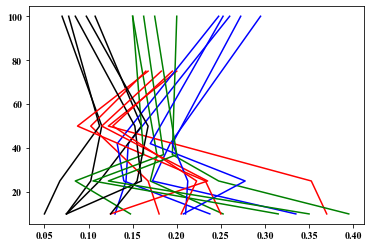

In [4]:
fig, ax = plt.subplots()
for i in range(len(moisture)):
    ax.plot(moisture[i][0:4],depth_moi[0:4],color='black')
    ax.plot(moisture[i][4:8],depth_moi[4:8],color='blue')
    ax.plot(moisture[i][8:12],depth_moi[8:12],color='red')
    ax.plot(moisture[i][12:16],depth_moi[12:16],color='green')

In [5]:
peakRate = {'A':[], 'B':[], 'C':[], 'D':[]}
flux = {'A':[], 'B':[], 'C':[], 'D':[]}
for j in np.arange(1,4):
    # iterate 5 days
    for i in range(5):
        A = Profile(depth_moi[0:4],moisture[i][0:4],depth_iso[0:12],d13C[i][0:12],-19)
        B = Profile(depth_moi[4:8],moisture[i][4:8],depth_iso[12:17],d13C[i][12:17],-25)
        C = Profile(depth_moi[8:12],moisture[i][8:12],depth_iso[17:22],d13C[i][17:22],-25)
        D = Profile(depth_moi[12:16],moisture[i][12:16],depth_iso[22:27],d13C[i][22:27],-25)
        # iterate three options
        peakRate['A'].append(A.fitIsotope(j))
        flux['A'].append(A.flux)
        peakRate['B'].append(B.fitIsotope(j))
        flux['B'].append(B.flux)
        peakRate['C'].append(C.fitIsotope(j))
        flux['C'].append(C.flux)
        peakRate['D'].append(D.fitIsotope(j))
        flux['D'].append(D.flux)

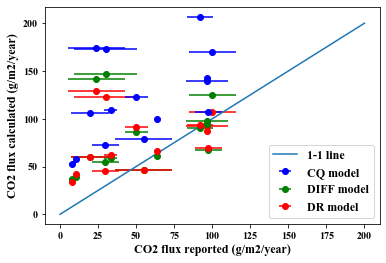

In [6]:
# Oerter et al. 2018 data
x = [1482, 1482, 1482, 1482, 1482, 1482, 1482, 1482, 1482, 1482, 1482, 1745, 1745, 1745,
     1745, 2140, 2140, 2140, 2140, 2602, 2602, 2602, 2602]
y = [235.84906,179.24529,122.64151,127.35849,226.4151,518.8679,580.18866,716.98114,768.8679,1084.9056,1146.2264,
     1264.151,551.8868,193.39622,75.471695,500,636.7925,910.3774,971.6981,325.4717,254.71698,150.94339,9.433962]
reported = [[238.5,297.4,298.7,999.6,964.7],[81.55,332.6,101.9,195.3,549.3],
            [502.2,921.8,638.7,963.6,974.1],[0,0,254.8,153.7,328.5]]
error = [[188.7,88.4,204.1,153.9,136.8],[23.88,44.39,13.45,123.5,189.2],
         [74.89,85.39,7.965,7.406,90.53],[0,0,6.094,9.255,436.5]]
reported = np.array(reported)/10
error = np.array(error)/10

fig, ax = plt.subplots()
# ax.scatter(x,y,color='black',s=50)
ax.errorbar(reported[0],flux['A'][0:5],xerr=error[0],fmt='o',color='blue')
ax.errorbar(reported[0],flux['A'][5:10],xerr=error[0],fmt='o',color='green')
ax.errorbar(reported[0],flux['A'][10:15],xerr=error[0],fmt='o',color='red')

ax.errorbar(reported[1],flux['B'][0:5],xerr=error[1],fmt='o',color='blue')
ax.errorbar(reported[1],flux['B'][5:10],xerr=error[1],fmt='o',color='green')
ax.errorbar(reported[1],flux['B'][10:15],xerr=error[1],fmt='o',color='red')

ax.errorbar(reported[2],flux['C'][0:5],xerr=error[2],fmt='o',color='blue')
ax.errorbar(reported[2],flux['C'][5:10],xerr=error[2],fmt='o',color='green')
ax.errorbar(reported[2],flux['C'][10:15],xerr=error[2],fmt='o',color='red')

# ax.errorbar(reported[3][2:],flux['D'][2:5],xerr=error[3][2:],fmt='o',color='blue')
# ax.errorbar(reported[3][2:],flux['D'][7:10],xerr=error[3][2:],fmt='o',color='green')
# ax.errorbar(reported[3][2:],flux['D'][12:15],xerr=error[3][2:],fmt='o',color='red')

ax.plot([0,200],[0,200])
ax.set_xlabel('CO2 flux reported (g/m2/year)', fontsize=12)
ax.set_ylabel('CO2 flux calculated (g/m2/year)', fontsize=12)
ax.legend(['1-1 line','CQ model','DIFF model','DR model'], fontsize=12)

# fig.savefig('comparison.pdf')

In [15]:
# Concatenate four lists for RMSE calculations
reportedRavel = list(reported[0]) + list(reported[1]) + list(reported[2])
CQRavel = flux['A'][0:5] + flux['B'][0:5] + flux['C'][0:5]
DIFFRavel = flux['A'][5:10] + flux['B'][5:10] + flux['C'][5:10]
DRRavel = flux['A'][10:15] + flux['B'][10:15] + flux['C'][10:15]

# Calculate RMSE
mseCQ = np.sqrt(mean_squared_error(CQRavel, reportedRavel))
mseDIFF = np.sqrt(mean_squared_error(DIFFRavel, reportedRavel))
mseDR = np.sqrt(mean_squared_error(DRRavel, reportedRavel))
print(mseCQ)
print(mseDIFF)
print(mseDR)

In [19]:
print(sum(CQRavel)/sum(DRRavel))
print(sum(DIFFRavel)/sum(DRRavel))
# print(sum(DRRavel)/sum(reportedRavel))

1.5766264861442236
1.047848015773966


In [21]:
fluxCQ = []
fluxDIFF = []
fluxDR = []
for i in range(5):
    for j in ['A','B','C']:
        fluxCQ.append(flux[j][i])
for i in np.arange(5,10):
    for j in ['A','B','C']:
        fluxDIFF.append(flux[j][i])
for i in np.arange(10,15):
    for j in ['A','B','C']:
        fluxDR.append(flux[j][i])
np.mean(fluxDR)/np.mean(y[0:-4])

0.13461533569105097

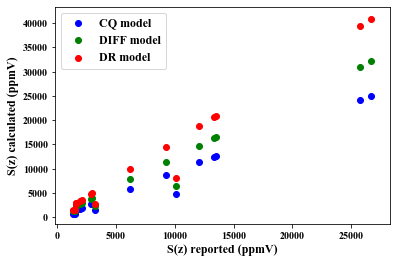

In [22]:
BreeckerJ = [55.5,26.1,57.6,20,28.8,29.2,13.5,3.5,11,3.5,6.3,3.6,4.2,3.6,4.6,6.5,1.7,1.5]
for i in range(len(BreeckerJ)):
    BreeckerJ[i] = BreeckerJ[i]*24*365/1000*12
BreeckerSz = [25700,12100,26700,9300,13300,13500,6200,3200,10100,1620,2920,1670,1940,1670,2130,3010,1560,1380]
# BreeckerMax = [25700,12100,26700,9300,13300,13500,6200,3200,10100]

# Start shooting
shoot = Profile([0,100],[0.05,0.2],depth_iso[0:12],d13C[0][0:12],-19)
CQ = []
DIFF = []
DR = []
for i in BreeckerJ:
    CQ.append(shoot.shooting(i,1))
    DIFF.append(shoot.shooting(i,2))
    DR.append(shoot.shooting(i,3))
# CQMin = [1260,2260,1290,1510,1290,1650,2330,610,540]
# CQMax = [19900,9380,20500,7190,10300,10500,4850,1260,3950]
# DIFFMin = [2160,3570,2210,2510,2210,2720,3670,1260,1160]
# DIFFMax = [28300,13500,29100,10500,14900,15100,7190,2160,5930]
# DRMin = [3250,5530,3330,3820,3330,4150,5690,1790,1620]
# DRMax = [45600,21700,46800,16700,23800,24200,11400,3250,9350]

# Plotting
fig, ax = plt.subplots()
ax.scatter(BreeckerSz,CQ,color='blue')
ax.scatter(BreeckerSz,DIFF,color='green')
ax.scatter(BreeckerSz,DR,color='red')
ax.set_xlabel('S(z) reported (ppmV)', fontsize=12)
ax.set_ylabel('S(z) calculated (ppmV)', fontsize=12)
ax.legend(['CQ model','DIFF model','DR model'], fontsize=12)
# ax.plot([0,30000],[0,30000],color='black',linewidth=2)

fig.savefig('plot.pdf')

In [23]:
moistureRange = [0.1,0.12,0.14,0.16,0.18,0.2]
percentageCQ = []
percentageDIFF = []
percentageDR = []
for i in moistureRange:
    # Start shooting
    shoot = Profile([0,100],[0.05,i],depth_iso[0:12],d13C[0][0:12],-19)
    CQ = []
    DIFF = []
    DR = []
    for j in BreeckerJ:
        try:
            CQ.append(shoot.shooting(j,1))
            DIFF.append(shoot.shooting(j,2))
            DR.append(shoot.shooting(j,3))
        except:
            print(i)
    percentageCQ.append(sum(CQ)/sum(BreeckerSz)*2500)
    percentageDIFF.append(sum(DIFF)/sum(BreeckerSz)*2500)
    percentageDR.append(sum(DR)/sum(BreeckerSz)*2500)

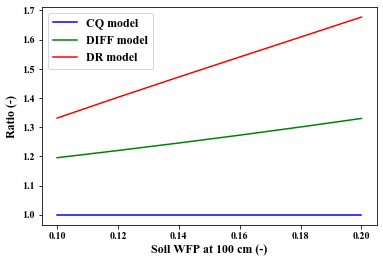

In [24]:
# Plotting
fig, ax = plt.subplots()
ax.plot(moistureRange,np.array(percentageCQ)/np.array(percentageCQ),color='blue')
ax.plot(moistureRange,np.array(percentageDIFF)/np.array(percentageCQ),color='green')
ax.plot(moistureRange,np.array(percentageDR)/np.array(percentageCQ),color='red')
ax.set_xlabel('Soil WFP at 100 cm (-)', fontsize=12)
ax.set_ylabel('Ratio (-)', fontsize=12)
ax.legend(['CQ model','DIFF model','DR model'], fontsize=12)

# ax2 = ax.twiny()
# ax2.plot([488,753],[2500,4000],color='black')
# ax2.plot([488,753],[2500-681,4000-681],color='black')
# ax2.plot([488,753],[2500+681,4000+681],color='black')
# ax2.plot([488,577],[2500,3000],color='black')
# ax2.plot([488,577],[2500-681,3000-681],color='black')
# ax2.plot([488,577],[2500+681,3000+681],color='black')
# ax2.set_xlabel('MAP (mm/yr)', fontsfdfize=12)

fig.savefig('Ratio.pdf')

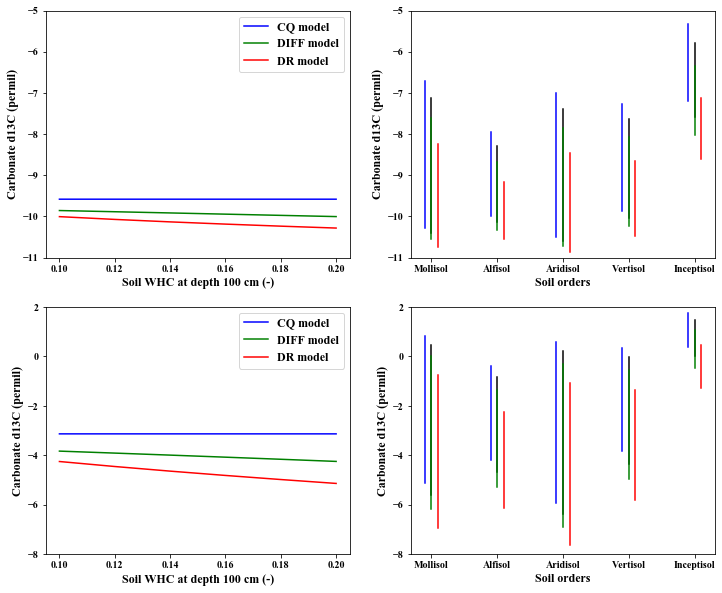

In [25]:
d13Cresp = -22
CO2air = 300
d13CCQ1 = (np.array(percentageCQ)*d13Cresp + CO2air*-6.5)/(np.array(percentageCQ) + CO2air)
d13CDIFF1 = (np.array(percentageDIFF)*d13Cresp + CO2air*-6.5)/(np.array(percentageDIFF) + CO2air)
d13CDR1 = (np.array(percentageDR)*d13Cresp + CO2air*-6.5)/(np.array(percentageDR) + CO2air)
d13CCQ1 = (d13CCQ1 + 1000) * ((11.98 - 0.12*10) / 1000 + 1) - 1000
d13CDIFF1 = (d13CDIFF1 + 1000) * ((11.98 - 0.12*10) / 1000 + 1) - 1000
d13CDR1 = (d13CDR1 + 1000) * ((11.98 - 0.12*10) / 1000 + 1) - 1000

CO2air = 2500
d13CCQ2 = (np.array(percentageCQ)*d13Cresp + CO2air*-6.5)/(np.array(percentageCQ) + CO2air)
d13CDIFF2 = (np.array(percentageDIFF)*d13Cresp + CO2air*-6.5)/(np.array(percentageDIFF) + CO2air)
d13CDR2 = (np.array(percentageDR)*d13Cresp + CO2air*-6.5)/(np.array(percentageDR) + CO2air)
d13CCQ2 = (d13CCQ2 + 1000) * ((11.98 - 0.12*10) / 1000 + 1) - 1000
d13CDIFF2 = (d13CDIFF2 + 1000) * ((11.98 - 0.12*10) / 1000 + 1) - 1000
d13CDR2 = (d13CDR2 + 1000) * ((11.98 - 0.12*10) / 1000 + 1) - 1000

# Different soil orders
CO2air = 300
soilOrder = np.array([[783., 4180.],
                      [1180., 3280.],
                      [858., 5217.],
                      [930., 3000.], # microhigh
                      [530., 910.]])
soilOrderCQ = soilOrder * percentageCQ[-1] / 2500
soilOrderDIFF = soilOrder * percentageDIFF[-1] / 2500
soilOrderDR = soilOrder * percentageDR[-1] / 2500
for i in range(len(soilOrder)):
    soilOrder[i] = (np.array(soilOrder[i])*d13Cresp + CO2air*-6.5)/(np.array(soilOrder[i]) + CO2air)
    soilOrder[i] = (soilOrder[i] + 1000) * ((11.98 - 0.12*10) / 1000 + 1) - 1000
    soilOrderCQ[i] = (np.array(soilOrderCQ[i])*d13Cresp + CO2air*-6.5)/(np.array(soilOrderCQ[i]) + CO2air)
    soilOrderCQ[i] = (soilOrderCQ[i] + 1000) * ((11.98 - 0.12*10) / 1000 + 1) - 1000
    soilOrderDIFF[i] = (np.array(soilOrderDIFF[i])*d13Cresp + CO2air*-6.5)/(np.array(soilOrderDIFF[i]) + CO2air)
    soilOrderDIFF[i] = (soilOrderDIFF[i] + 1000) * ((11.98 - 0.12*10) / 1000 + 1) - 1000
    soilOrderDR[i] = (np.array(soilOrderDR[i])*d13Cresp + CO2air*-6.5)/(np.array(soilOrderDR[i]) + CO2air)
    soilOrderDR[i] = (soilOrderDR[i] + 1000) * ((11.98 - 0.12*10) / 1000 + 1) - 1000

# Different soil orders
CO2air = 2500
soilOrder2 = np.array([[783., 4180.],
                       [1180., 3280.],
                       [858., 5217.],
                       [930., 3000.], # microhigh
                       [530., 910.]])
soilOrderCQ2 = soilOrder2 * percentageCQ[-1] / 2500
soilOrderDIFF2 = soilOrder2 * percentageDIFF[-1] / 2500
soilOrderDR2 = soilOrder2 * percentageDR[-1] / 2500
for i in range(len(soilOrder)):
    soilOrder2[i] = (np.array(soilOrder2[i])*d13Cresp + CO2air*-6.5)/(np.array(soilOrder2[i]) + CO2air)
    soilOrder2[i] = (soilOrder2[i] + 1000) * ((11.98 - 0.12*10) / 1000 + 1) - 1000
    soilOrderCQ2[i] = (np.array(soilOrderCQ2[i])*d13Cresp + CO2air*-6.5)/(np.array(soilOrderCQ2[i]) + CO2air)
    soilOrderCQ2[i] = (soilOrderCQ2[i] + 1000) * ((11.98 - 0.12*10) / 1000 + 1) - 1000
    soilOrderDIFF2[i] = (np.array(soilOrderDIFF2[i])*d13Cresp + CO2air*-6.5)/(np.array(soilOrderDIFF2[i]) + CO2air)
    soilOrderDIFF2[i] = (soilOrderDIFF2[i] + 1000) * ((11.98 - 0.12*10) / 1000 + 1) - 1000
    soilOrderDR2[i] = (np.array(soilOrderDR2[i])*d13Cresp + CO2air*-6.5)/(np.array(soilOrderDR2[i]) + CO2air)
    soilOrderDR2[i] = (soilOrderDR2[i] + 1000) * ((11.98 - 0.12*10) / 1000 + 1) - 1000

fig, ax = plt.subplots(2, 2, figsize=(12,10))
ax[0][0].plot(moistureRange,d13CCQ1,color='blue')
ax[0][0].plot(moistureRange,d13CDIFF1,color='green')
ax[0][0].plot(moistureRange,d13CDR1,color='red')
ax[0][0].set_xlabel('Soil WHC at depth 100 cm (-)', fontsize=12)
ax[0][0].set_ylabel('Carbonate d13C (permil)', fontsize=12)
ax[0][0].legend(['CQ model','DIFF model','DR model'], fontsize=12)
ax[0][0].set_ylim(-11,-5)

ax[1][0].plot(moistureRange,d13CCQ2,color='blue')
ax[1][0].plot(moistureRange,d13CDIFF2,color='green')
ax[1][0].plot(moistureRange,d13CDR2,color='red')
ax[1][0].set_xlabel('Soil WHC at depth 100 cm (-)', fontsize=12)
ax[1][0].set_ylabel('Carbonate d13C (permil)', fontsize=12)
ax[1][0].legend(['CQ model','DIFF model','DR model'], fontsize=12)
ax[1][0].set_ylim(-8,2)

for i in range(5):
    ax[0][1].plot([i+1,i+1],soilOrder[i],color='black')
    ax[0][1].plot([i+1-0.1,i+1-0.1],soilOrderCQ[i],color='blue')
    ax[0][1].plot([i+1,i+1],soilOrderDIFF[i],color='green')
    ax[0][1].plot([i+1+0.1,i+1+0.1],soilOrderDR[i],color='red')
ax[0][1].set_xlabel('Soil orders', fontsize=12)
ax[0][1].set_ylabel('Carbonate d13C (permil)', fontsize=12)
# ax[0][1].legend(['CQ model','DIFF model','DR model'], fontsize=12)
ax[0][1].set_xticks([1,2,3,4,5])
ax[0][1].set_xticklabels(['Mollisol','Alfisol','Aridisol','Vertisol','Inceptisol'])
ax[0][1].set_ylim(-11,-5)

for i in range(5):
    ax[1][1].plot([i+1,i+1],soilOrder2[i],color='black')
    ax[1][1].plot([i+1-0.1,i+1-0.1],soilOrderCQ2[i],color='blue')
    ax[1][1].plot([i+1,i+1],soilOrderDIFF2[i],color='green')
    ax[1][1].plot([i+1+0.1,i+1+0.1],soilOrderDR2[i],color='red')
ax[1][1].set_xlabel('Soil orders', fontsize=12)
ax[1][1].set_ylabel('Carbonate d13C (permil)', fontsize=12)
# ax[1][1].legend(['CQ model','DIFF model','DR model'], fontsize=12)
ax[1][1].set_xticks([1,2,3,4,5])
ax[1][1].set_xticklabels(['Mollisol','Alfisol','Aridisol','Vertisol','Inceptisol'])
ax[1][1].set_ylim(-8,2)

fig.savefig('DanPlot.pdf')

In [26]:
from math import ceil
import numpy as np
from scipy import linalg

def lowess_ag(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

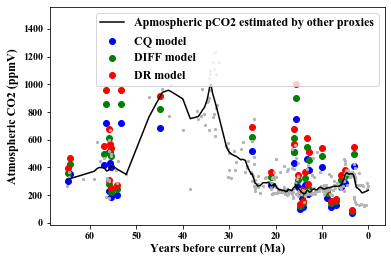

In [27]:
data = pd.read_excel('./41561_2011_BFngeo1186_MOESM242_ESM.xls')
data = data[0:366]
mask = data['Method'].isin(['Paleosols'])
# Normalizing values for other methods
age = []
CO2 = []
for i in data[~mask].index:
    if data[~mask]['Age (Ma)'][i] not in age:
        age.append(data[~mask]['Age (Ma)'][i])
        CO2.append(data[~mask]['CO2 (ppm)'][i])
    else:
        age[-1] = np.mean([age[-1],data[~mask]['Age (Ma)'][i]])
        CO2[-1] = np.mean([age[-1],data[~mask]['CO2 (ppm)'][i]])
# Normalizing values for paleosols
ageModel = []
CQ = []
DIFF = []
DR = []
for i in data[mask].index:
    if data[mask]['Age (Ma)'][i] not in ageModel:
        ageModel.append(data[mask]['Age (Ma)'][i])
        CQ.append(data[mask]['CO2 (ppm)'][i]*percentageCQ[0]/2500)
        DIFF.append(data[mask]['CO2 (ppm)'][i]*percentageDIFF[0]/2500)
        DR.append(data[mask]['CO2 (ppm)'][i]*percentageDR[0]/2500)
    else:
        CQ[-1] = np.mean([CQ[-1],data[mask]['CO2 (ppm)'][i]*percentageCQ[0]/2500])
        DIFF[-1] = np.mean([DIFF[-1],data[mask]['CO2 (ppm)'][i]*percentageDIFF[0]/2500])
        DR[-1] = np.mean([DR[-1],data[mask]['CO2 (ppm)'][i]*percentageDR[0]/2500])
f = 0.05
f2 = 0.1
CO2est = lowess_ag(np.array(age),np.array(CO2),f=f)
CQest = lowess_ag(np.array(ageModel),np.array(CQ),f=f2)
DIFFest = lowess_ag(np.array(ageModel),np.array(DIFF),f=f2)
DRest = lowess_ag(np.array(ageModel),np.array(DR),f=f2)

# Plotting
fig, ax = plt.subplots()
ax.plot(age,CO2est,color='black')
ax.scatter(ageModel,CQ,color='blue')
ax.scatter(ageModel,DIFF,color='green')
ax.scatter(ageModel,DR,color='red')
ax.scatter(age,CO2,color=[0.7,0.7,0.7],s=5)
ax.set_xlabel('Years before current (Ma)', fontsize=12)
ax.set_ylabel('Atmospheric CO2 (ppmV)', fontsize=12)
ax.legend(['Apmospheric pCO2 estimated by other proxies','CQ model','DIFF model','DR model'], fontsize=12)
ax.invert_xaxis()
fig.savefig('OtherProxies.pdf')

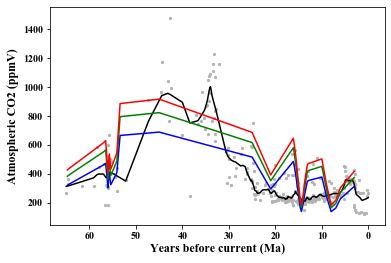

In [28]:
# Plotting
fig, ax = plt.subplots()
ax.plot(age,CO2est,color='black')
ax.scatter(age,CO2,color=[0.7,0.7,0.7],s=5)
ax.plot(ageModel,CQest,color='blue')
ax.plot(ageModel,DIFFest,color='green')
ax.plot(ageModel,DRest,color='red')
ax.set_xlabel('Years before current (Ma)', fontsize=12)
ax.set_ylabel('Atmospheric CO2 (ppmV)', fontsize=12)
ax.invert_xaxis()

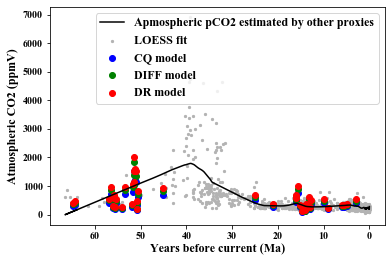

In [29]:
data = pd.read_excel('Lydia+Clara_CO2Compilation_12JAN2020.xlsx')
mask = data['Method'].isin(['Paleosols'])
# Normalizing values for other methods
age = []
CO2 = []
for i in data[~mask].index:
    if data[~mask]['Age'][i] not in age:
        age.append(data[~mask]['Age'][i])
        CO2.append(data[~mask]['CO2'][i])
    else:
        age[-1] = np.mean([age[-1],data[~mask]['Age'][i]])
        CO2[-1] = np.mean([age[-1],data[~mask]['CO2'][i]])
# Normalizing values for paleosols
ageModel = []
CQ = []
DIFF = []
DR = []
for i in data[mask].index:
    if data[mask]['Age'][i] not in ageModel:
        ageModel.append(data[mask]['Age'][i])
        CQ.append(data[mask]['CO2'][i]*percentageCQ[0]/2500)
        DIFF.append(data[mask]['CO2'][i]*percentageDIFF[0]/2500)
        DR.append(data[mask]['CO2'][i]*percentageDR[0]/2500)
    else:
        CQ[-1] = np.mean([CQ[-1],data[mask]['CO2'][i]*percentageCQ[0]/2500])
        DIFF[-1] = np.mean([DIFF[-1],data[mask]['CO2'][i]*percentageDIFF[0]/2500])
        DR[-1] = np.mean([DR[-1],data[mask]['CO2'][i]*percentageDR[0]/2500])
f = 0.05
f2 = 0.1
CO2est = lowess_ag(np.array(age),np.array(CO2),f=f)
CQest = lowess_ag(np.array(ageModel),np.array(CQ),f=f2)
DIFFest = lowess_ag(np.array(ageModel),np.array(DIFF),f=f2)
DRest = lowess_ag(np.array(ageModel),np.array(DR),f=f2)

# Plotting
fig, ax = plt.subplots()
ax.scatter(age,CO2,color=[0.7,0.7,0.7],s=5)
ax.plot(age,CO2est,color='black')
ax.scatter(ageModel,CQ,color='blue')
ax.scatter(ageModel,DIFF,color='green')
ax.scatter(ageModel,DR,color='red')
ax.set_xlabel('Years before current (Ma)', fontsize=12)
ax.set_ylabel('Atmospheric CO2 (ppmV)', fontsize=12)
ax.legend(['Apmospheric pCO2 estimated by other proxies','LOESS fit','CQ model','DIFF model','DR model'], fontsize=12)
ax.invert_xaxis()
# fig.savefig('OtherProxies.pdf')

In [30]:
# Read in Foster's LOESS fit
loessfit = pd.read_excel('./41467_2017_BFncomms14845_MOESM2875_ESM.xlsx')

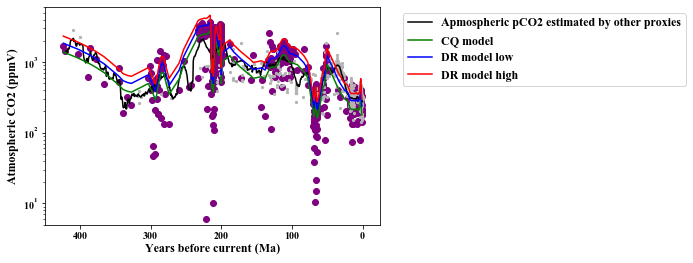

In [31]:
data = pd.read_excel('Foster_et_al_2017_sup.xlsx')
dataOthers = data[524:]
dataCarbonate = data[0:524]
# Normalizing values for other methods
age = []
CO2 = []
for i in dataOthers.index:
    if dataOthers['Age'][i] not in age:
        age.append(dataOthers['Age'][i])
        CO2.append(dataOthers['CO2'][i])
    else:
        age[-1] = np.mean([age[-1],dataOthers['Age'][i]])
        CO2[-1] = np.mean([age[-1],dataOthers['CO2'][i]])
age, CO2 = zip(*sorted(zip(age, CO2)))
# Normalizing values for paleosols
ageModel = []
original = []
CQ = []
DRlow = []
DRhigh = []
for i in dataCarbonate.index:
    if dataCarbonate['Age'][i] not in ageModel:
        ageModel.append(dataCarbonate['Age'][i])
        original.append(dataCarbonate['CO2'][i])
        CQ.append(dataCarbonate['CO2'][i]*percentageCQ[0]/2500)
        DRlow.append(dataCarbonate['CO2'][i]*percentageDR[0]/2500)
        DRhigh.append(dataCarbonate['CO2'][i]*percentageDR[5]/2500)
    else:
        original[-1] = np.mean([original[-1],dataCarbonate['CO2'][i]])
        CQ[-1] = np.mean([CQ[-1],dataCarbonate['CO2'][i]*percentageCQ[0]/2500])
        DRlow[-1] = np.mean([DRlow[-1],dataCarbonate['CO2'][i]*percentageDR[0]/2500])
        DRhigh[-1] = np.mean([DRhigh[-1],dataCarbonate['CO2'][i]*percentageDR[5]/2500])
ageModel, original, CQ, DRlow, DRhigh = zip(*sorted(zip(ageModel, original, CQ, DRlow, DRhigh)))
f = 0.02
f2 = 0.05
CO2est = lowess_ag(np.array(age),np.array(CO2),f=f)
CQest = lowess_ag(np.array(ageModel),np.array(CQ),f=f2)
DRlowest = lowess_ag(np.array(ageModel),np.array(DRlow),f=f2)
DRhighest = lowess_ag(np.array(ageModel),np.array(DRhigh),f=f2)

# Plotting
fig, ax = plt.subplots()
ax.plot(loessfit['Age (Ma)'],loessfit['pCO2 probability maximum'],color='black')
ax.scatter(ageModel,original,color='purple')
# ax.scatter(ageModel,DRlow,color='blue')
# ax.scatter(ageModel,DRhigh,color='red')
ax.scatter(age,CO2,color=[0.7,0.7,0.7],s=5)
ax.plot(ageModel,CQest,color='green')
ax.plot(ageModel,DRlowest,color='blue')
ax.plot(ageModel,DRhighest,color='red')
ax.set_xlabel('Years before current (Ma)', fontsize=12)
ax.set_ylabel('Atmospheric CO2 (ppmV)', fontsize=12)
ax.legend(['Apmospheric pCO2 estimated by other proxies','CQ model','DR model low','DR model high'], fontsize=12, 
          bbox_to_anchor=(1.05, 1))
ax.invert_xaxis()
plt.ylim((5,6000))
plt.yscale('log')
fig.savefig('Foster.pdf')

In [32]:
# Sieve out data without soil order reported
mask = dataCarbonate['Notes'].isin([np.NaN])
# Characterization of the soils
charSoil = {'CO2' : [],
            'Notes' : [],
            'Sz' : [],
            'age' : []}
for i in dataCarbonate[~mask].index:
    charSoil['CO2'].append(dataCarbonate[~mask]['CO2'][i])
    charSoil['Sz'].append(dataCarbonate[~mask]['S(z) used'][i])
    charSoil['Notes'].append(dataCarbonate[~mask]['Notes'][i].split(', '))
    charSoil['age'].append(dataCarbonate[~mask]['Age'][i])
# Set up color scheme
colorscheme = {'Vertisol' : 'green',  # Clay rich, seasonally humid or subject to erratic droughts and floods
               'Aridisol' : 'yellow', # Arid
               'Inceptisol' : 'blue', # Clay poor, organic poor
               'Calcisol' : 'black',  # Calcic
               'Alfisol' : 'red',     # Semi-arid to humid
               'Mollisol' : 'purple', # Organic rich
               'Loess' : 'brown',     # Losely compiled
               'Histosol' : [0.8,0.8,0.8]} # Organic rich
soilOrder = []
for i in charSoil['Notes']:
    soilOrder.append(i[0])

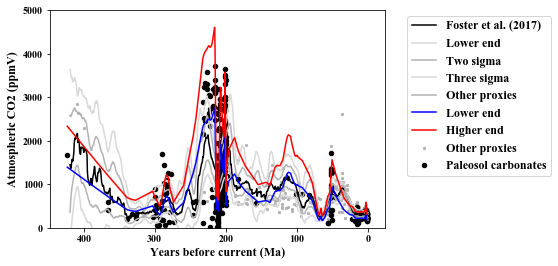

In [48]:
# Plotting
fig, ax = plt.subplots()
ax.plot(loessfit['Age (Ma)'],loessfit['pCO2 probability maximum'],color='black')
ax.plot(loessfit['Age (Ma)'],loessfit['up95%'],color=[0.85,0.85,0.85])
ax.plot(loessfit['Age (Ma)'],loessfit['up68%'],color=[0.7,0.7,0.7])
ax.plot(loessfit['Age (Ma)'],loessfit['lw95%'],color=[0.85,0.85,0.85])
ax.plot(loessfit['Age (Ma)'],loessfit['lw68%'],color=[0.7,0.7,0.7])
ax.scatter(age,CO2,color=[0.7,0.7,0.7],s=5)
ax.plot(ageModel,CQest,color='blue')
# ax.plot(ageModel,DRlowest,color='blue')
ax.plot(ageModel,DRhighest,color='red')
# ax.scatter(charSoil['age'],charSoil['CO2'],color=[colorscheme[i] for i in soilOrder])
ax.scatter(charSoil['age'],charSoil['CO2'],color='black',s=20)
ax.set_xlabel('Years before current (Ma)', fontsize=12)
ax.set_ylabel('Atmospheric CO2 (ppmV)', fontsize=12)
# ax.set_xlim(200,220)
ax.legend(['Foster et al. (2017)','Lower end','Two sigma','Three sigma','Other proxies',
           'Lower end','Higher end','Other proxies','Paleosol carbonates'], 
          fontsize=12, bbox_to_anchor=(1.05, 1))
ax.invert_xaxis()
plt.ylim((0,5000))
# plt.yscale('log')
fig.savefig('Zoomin.pdf')

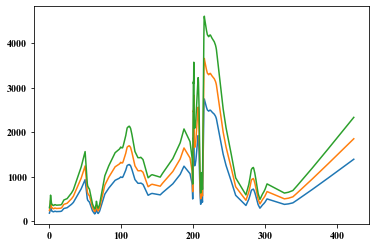

In [34]:
output = {'Age (Ma)' : ageModel,
            'CQ loess' : CQest,
            'DR low loess' : DRlowest,
            'DR high loess' : DRhighest}
outputdf = pd.DataFrame(output)

# outputdf.to_csv('LOESSFitToDan.csv')
plt.plot(outputdf['Age (Ma)'], outputdf['CQ loess'])
plt.plot(outputdf['Age (Ma)'], outputdf['DR low loess'])
plt.plot(outputdf['Age (Ma)'], outputdf['DR high loess'])

In [35]:
alltypes = []
for i in dataCarbonate[~mask].index:
    if dataCarbonate[~mask]['Notes'][i] not in alltypes:
        alltypes.append(dataCarbonate[~mask]['Notes'][i])
alltypes

['Vertisol',
 'Aridisol',
 'Inceptisol',
 'Calcisol',
 'Aridisol, Vertisol',
 'Vertisol, Histosol',
 'Aridisol, Vertisol, Alfisol',
 'Aridisol, Alfisol',
 'Inceptisol, Entisol, Alfisol',
 'Alfisol, Inceptisol',
 'Mollisol',
 'Alfisol',
 'Loess',
 'Vertisol, Inceptisol']